In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mapping import map_str_values
from sklearn import metrics


## Data

In [2]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
Y = pd.read_csv("data/train_labels.csv", index_col="building_id") - 1
# X = map_str_values(X)

## Áp dụng one hot encode cho các biến phân loại 

In [4]:
X = pd.get_dummies(X, dtype=int)
X.dtypes

geo_level_1_id              int64
geo_level_2_id              int64
geo_level_3_id              int64
count_floors_pre_eq         int64
age                         int64
                            ...  
plan_configuration_u        int32
legal_ownership_status_a    int32
legal_ownership_status_r    int32
legal_ownership_status_v    int32
legal_ownership_status_w    int32
Length: 68, dtype: object

## Chia train, test

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=192)
X_train.shape

(195450, 68)

## Model MixedNB kết hợp giữa GaussianNB và BernouliNB (Tự code)

In [24]:
class MixedNB():
    def __init__(self, gauss_index=None, bernouli_index=None):
        self.gauss_index = gauss_index # Index để tính xs của gauss
        self.bernouli_index = bernouli_index # Index để tính xs của bernouli


    def fit(self, X, Y): # Lưu trữ, tính toán những tham số cần thiết cho 2 mô hình gaussianNB và bernouliNB
        self.classes = np.unique(np.array(Y))
        self.n_features = X.shape[1]
        n_class = len(self.classes)
        self.class_priors = np.empty(shape=(n_class))

        self._calculate_stuffs(X, Y)

    def _calculate_stuffs(self, X, Y): # Tính toán means, vars, các P(i|c)  
        P_ic = []
        means = []
        vars_ = []

        for k, c in enumerate(self.classes): # Lặp qua tất cả các class
            Xc = X.iloc[np.where(Y == c)] # Lấy ra các X có cùng class
            temp = [] # Mảng lưu trữ các xs P(i|C) của class c
            temp_mean = [] # Mảng lưu trữ các mean của class c 
            temp_var = [] # Mảng lưu trữ các var của class c
            self.class_priors[k] = (len(Xc)) / (len(X)) # Tính toán xs prior của class c
            
            for i in range(X.shape[1]): # Lặp qua tất cả các feature của các record có cùng class c
                feat_probs_c = np.sum(Xc.iloc[:, i]) / len(Xc)

                temp.append(feat_probs_c)
                temp_mean.append(np.mean(Xc.iloc[:, i]))
                temp_var.append(np.var(Xc.iloc[:, i]))

            P_ic.append(temp)
            means.append(temp_mean)
            vars_.append(temp_var)

        # Lưu trữ các ma trận xs, means, vars của tất cả các class
        self.P_ic = np.array(P_ic)
        self.means = np.array(means)
        self.vars = np.array(vars_)


    def _pdf_binomial(self, x, feat_probs_class): # Hàm pdf của pp nhị thức
        return (feat_probs_class ** x) * ((1 - feat_probs_class) ** (1 - x))
    

    def _pdf_gauss(self, x, mean, variance): # Hàm pdf của pp gauss
        exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
        return (1 / np.sqrt(2 * np.pi * variance)) * exponent
    
    
    def _get_joint_probs(self, X): # Tính toán các xs posteriors

        class_probs = [] 
        for x in X:
            # print(x)
            posts = []

            for i in range(len(self.class_priors)):
                post = np.log(self.class_priors[i]) # Lấy ra xs priors ứng với class thứ i

                for j in range(X.shape[1]): # Xét theo index truyền vào để quyết định xem tính toán với pdf nào
                    # print("buoi")
                    if j in self.gauss_index:
                        post += np.log(self._pdf_gauss(x=x[j], mean=self.means[i,j], variance=self.vars[i, j]))
                    elif j in self.bernouli_index:
                        # print("loz")
                        post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))

                posts.append(post)
            class_probs.append(posts)

        return np.array(class_probs)
    
    
    def predict(self, X):
        probs = self._get_joint_probs(X)
        # print(probs)
        Y_preds = []
        for prob in probs: # Lặp qua tất cả các xs posteriors
            Y_preds.append(self.classes[np.argmax(prob)]) # Lấy index của xs max => Phân loại

        return np.array(Y_preds)



- Do bộ data có nhiều loại dữ liệu, cụ thể là feature từ (0-6) là liên tục, feature (7-n) là binary (Do đã áp dụng one hot encode) nên chúng ta có thể truyền dữ liệu index dưới dạng range

In [25]:
mixNB = MixedNB(range(0, 6), range(7,X_train.shape[1]))
mixNB.fit(X_train, Y_train["damage_grade"])


In [26]:
preds = mixNB.predict(X_test.to_numpy())
preds.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_14276\3629321643.py:68: RuntimeWarning: invalid value encountered in log
  post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_14276\3629321643.py:68: RuntimeWarning: divide by zero encountered in log
  post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))


(65151,)

- Do code chưa tối ưu về thuật toán nên thời gian chạy khá lâu (20 - 30s) nhưng độ chính xác cũng không quá kém với những mô hình NB khác 

In [23]:
print(metrics.classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.39      0.43      0.41      6275
           1       0.65      0.32      0.43     37165
           2       0.40      0.74      0.52     21711

    accuracy                           0.47     65151
   macro avg       0.48      0.50      0.45     65151
weighted avg       0.54      0.47      0.46     65151



[[ 2683  1301  2291]
 [ 3652 11847 21666]
 [  533  5098 16080]]


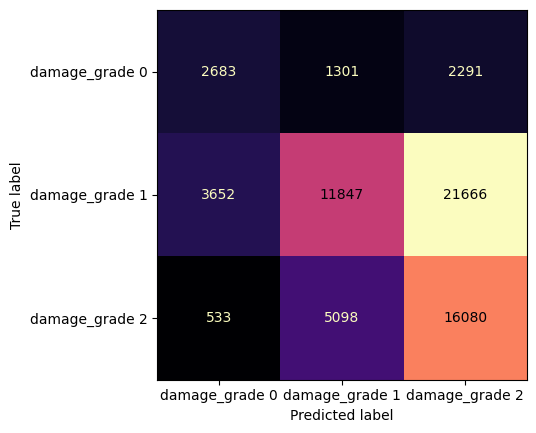

In [45]:
cm = metrics.confusion_matrix(Y_test, preds)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma", colorbar=False)
print(cm)